In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('train.dat', header = None)

data.head()

,0
0,13273 1 557 1 478 1 957 1 1230 1 53 2 55 1 91 ...
1,196 1 8699 4 47134 1 958 1 976 2 13459 1 3331 ...
2,619 1 556 1 973 1 14187 1 877 1 1414 2 3171 1 ...
3,556 2 14247 2 11 1 32069 1 14528 1 678 2 597 1...
4,17071 5 10682 4 596 1 678 3 52 3 53 1 55 2 341...


In [3]:
from scipy.sparse import csr_matrix

# number of rows
nrows = len(data)
# number of columns
ncols = 0
# number of nonzeroes
nnz = 0

for row in data[0]:
    temp_row = row.split()[::2]
    nnz += len(row)/2
    for word in temp_row:
        colid = int(word) - 1
        if (colid + 1 > ncols):
            ncols = colid + 1

dat = np.zeros(int(nnz), dtype = int)
cols = np.zeros(int(nnz), dtype = int)
index_ptr = np.zeros(nrows + 1, dtype = int)
n = 0

for i in range(nrows):
    line = data[0][i].split()
    for j in range(0, len(line), 2):
        cols[n] = int(line[j]) - 1
        dat[n] = int(line[j+1])
        n = n+1
    index_ptr[i+1] = n

traindata = csr_matrix((dat, cols, index_ptr), shape = (nrows, ncols), dtype = int)

In [4]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components = 725)
traindata = tsvd.fit(traindata).transform(traindata)

print(tsvd.explained_variance_ratio_.sum())

0.8211680165269843


In [5]:
from sklearn.cluster import KMeans
kmeansclusters = KMeans(n_clusters = 101, random_state = 0).fit(traindata)

centers = kmeansclusters.cluster_centers_

In [6]:
from scipy.spatial import distance

def close_points(data, pt, eps):
    points = []
    indicies = []
    for i in range(len(data)):
        if (distance.cosine(data[i], pt) <= eps and distance.cosine(data[i], pt) != 0):
            points.append(data[i])
            indicies.append(i)
    return points, indicies

In [7]:
def dbscan(eps, minpts, centers):
    class_labels = [0] * len(centers)
    allNeighbors = [0] * len(centers)
    corepts = []
    otherpts = []

    for i in range(len(centers)):
        p = centers[i]

        neighbors, idxs = close_points(centers, p, eps)
        # check if # of points is more than minpts to make it a core point
        if len(neighbors) > minpts:
            corepts.append((p, neighbors))
            class_labels[i] = 1
            allNeighbors[i] = idxs
        else:
            class_labels[i] = 2
            allNeighbors[i] = idxs
            otherpts.append((p, neighbors))

    # go through all points again to classify border and noise points
    # if a point x is not a core point but a point within eps of x is a core point, x is a border point

    #this code below is mostly useless and only useful for assignment of noise points later

    borderpts = []
    noisepts = []
    v = -1
    for j in range(len(class_labels)):
        if class_labels[j] == 2:
            v += 1
            neighs = otherpts[v][1]
            borderFound = False
            for k in [x[0] for x in corepts]:
                # for each core point, check whether that core point is within neighs
                for nei in neighs:
                    # for each neighbor, check if equal to the core point being looked for
                    if (np.array_equal(k, nei) and not borderFound):
                        # tuple is the border point and the core point it borders
                        borderpts.append((otherpts[v][0], k))
                        borderFound = True
            
            if(not borderFound):
                noisepts.append(otherpts[v][0])
                class_labels[j] = 0

    return class_labels, allNeighbors

In [8]:
from random import seed
from random import randint

def create_clusters(classLabels, allNeighbors, centers):
    clusterLabels = [0] * len(centers)
    count = 1
    seed(1)
    for i in range(len(centers)):
        # check if point is already in a cluster
        pt = centers[i]
        
        if(clusterLabels[i] != 0):
            # find the cluster it is in
            c = clusterLabels[i]
        else:
            # create a new cluster
            if classLabels[i] == 0:
                clusterLabels[i] = randint(1, count)
            else:
                c = count
                clusterLabels[i] = c
                for w in allNeighbors[i]:
                    clusterLabels[w] = c
                count += 1
            # for each neighbor, add to cluster c
    print("# clusters: " + str(count - 1))
    return clusterLabels

In [9]:
# for each of the points, find out which kmeans cluster is it the centroid of
# make an array with the cluster assignments and then print to output
def assign_final_clusters(clusterLabels):
    finalClusters = [None] * traindata.shape[0]

    # centers[0] is the center of all the vectors in the 0th cluster (there are clusters 0 - 100)
    for i in range(len(centers)):
        for j in range(len(kmeansclusters.labels_)):
            if kmeansclusters.labels_[j] == i:
                finalClusters[j] = clusterLabels[i]
    return finalClusters

In [10]:
from sklearn.metrics import calinski_harabasz_score

def get_score(traindata, finalClusters):
    return calinski_harabasz_score(traindata, finalClusters)

# clusters: 15
eps: 0.48 minpts: 3 score: 92.27549551969985
# clusters: 14
eps: 0.48 minpts: 5 score: 96.02306016959542
# clusters: 14
eps: 0.48 minpts: 7 score: 96.02306016959542
# clusters: 13
eps: 0.48 minpts: 9 score: 90.00001169873896
# clusters: 11
eps: 0.48 minpts: 11 score: 88.06213640897576
# clusters: 9
eps: 0.48 minpts: 13 score: 98.10011761107775
# clusters: 9
eps: 0.48 minpts: 15 score: 98.10011761107775
# clusters: 10
eps: 0.48 minpts: 17 score: 84.78629671271152
# clusters: 9
eps: 0.48 minpts: 19 score: 98.96102010167253
# clusters: 9
eps: 0.48 minpts: 21 score: 98.96102010167253
# clusters: 7
eps: 0.48 minpts: 23 score: 102.22600652557232
# clusters: 7
eps: 0.48 minpts: 25 score: 102.22600652557232


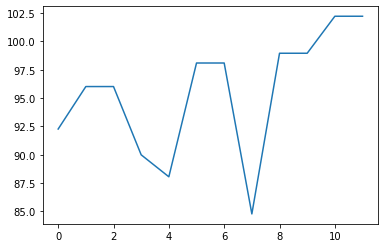

In [14]:
import matplotlib.pyplot as plt

scores = []
for m in range(3, 27, 2):
    eps = .48
    classLabels, allNeighbors = dbscan(eps, m, centers)
    clusterLabels = create_clusters(classLabels, allNeighbors, centers)
    final_clusters = assign_final_clusters(clusterLabels)
    score = get_score(traindata, final_clusters)
    scores.append(score)
    print("eps: " + str(eps) + " minpts: " + str(m) + " score: " + str(score))

plt.plot(scores)
plt.show()

In [13]:
test_predictions_file = open('output2.txt', 'w+')
pd.Series(final_clusters).to_csv("output2.txt", index = False, header = None)
test_predictions_file.close()